# Black-Box Attack on a Traffic Sign Classification Model

In [1]:
import numpy as np
import pandas as pd
import warnings
from pathlib import Path
from imageio import imread
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

from skimage.transform import resize
from skimage.color import rgb2hsv, hsv2rgb
from skimage.io import imread
from skimage.exposure import equalize_hist

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from keras.applications import *
from keras.models import Model, Sequential
from keras.optimizers import *
from keras.layers import *
from keras.utils import to_categorical

from art.attacks.fast_gradient import FastGradientMethod

np.random.seed(34)

Using TensorFlow backend.


## Data Loading and Preprocessing

In [2]:
# ! mkdir data
# ! wget http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip -P data
# ! wget http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_Images.zip -P data
# ! wget http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_GT.zip -P data
# ! unzip data/GTSRB_Final_Training_Images.zip -d data
# ! unzip data/GTSRB_Final_Test_Images.zip -d data
# ! unzip data/GTSRB_Final_Test_GT.zip -d data
# ! wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv -P data
# ! rm data/*.zip

In [3]:
def preprocess_image(image,size=48):
    # histogram normalization in v channel
    hsv = rgb2hsv(image)
    hsv[:,:,2] = equalize_hist(hsv[:,:,2])
    image = hsv2rgb(hsv)
    # central square crop
    min_side = min(image.shape[:-1])
    center = image.shape[0] // 2, image.shape[1] // 2
    image = image[center[0]-min_side//2:center[0]+min_side//2,center[1]-min_side//2:center[1]+min_side//2,:]
    # rescale to standard size
    image = resize(image, (size,size))
    # roll color axis to axis 0
    # image = np.rollaxis(image, -1)
    return image

def get_class(image_path):
    return int(str(image_path).split('/')[-2])

def plot_image(image, class_name=None):
    _, ax = plt.subplots(figsize=(5,5))
    if len(image.shape)<3:
        cmap = cm.gray
    else:
        cmap = None
    ax.imshow(image, cmap=cmap)
    ax.axis('off')
    if class_name is not None:
        ax.set_title(class_name)
    plt.show()
    
def plot_stacked_images(X, y=None, n=4, size=48):
    idx = np.random.choice(len(X),n**2,replace=False)
    _,ax = plt.subplots(nrows=n,ncols=n,figsize=(16,16))
    cnt = 0
    for i in range(n):
        for j in range(n):
            ax[i,j].imshow(X[idx[cnt]])
            ax[i,j].axis('off')
            if y is not None:
                ax[i,j].set_title(class_names[y[idx[cnt]]])
            cnt += 1
    plt.show()

In [4]:
warnings.filterwarnings('ignore')

data_dir = Path('./data')

bbox_dir = data_dir/'GTSRB/Final_Training/Images'
X_bbox = []
y_bbox = []

size = 48
n_max = -1

image_paths = list(bbox_dir.glob('*/*.ppm'))
np.random.shuffle(image_paths)
for image_path in tqdm(image_paths[:n_max]):
    image = imread(image_path)
    image = preprocess_image(image,size=size)
    X_bbox.append(image)
    label = get_class(image_path)
    y_bbox.append(label)

X_bbox = np.array(X_bbox, dtype='float32')
y_bbox = np.array(y_bbox, dtype=int)
Y_bbox = to_categorical(y_bbox,num_classes=43)

In [5]:
sub_dir = data_dir/'GTSRB/Final_Test/Images'

sub = pd.read_csv(data_dir/'GT-final_test.csv',sep=';')

# Load test dataset
X_sub = []
y_sub = []
zipped = list(zip(list(sub.Filename),list(sub.ClassId)))
for file_name, class_id in tqdm(zipped[:n_max]):
    image_path = data_dir/'GTSRB/Final_Test/Images'/file_name
    X_sub.append(preprocess_image(imread(image_path),size=size))
    y_sub.append(class_id)

X_sub = np.array(X_sub, dtype='float32')
y_sub = np.array(y_sub, dtype=int)
Y_sub = to_categorical(y_sub,num_classes=43)

In [6]:
classes = pd.read_csv('data/signnames.csv')
class_names = {}
for _,row in classes.iterrows():
    class_names[row[0]] = row[1]

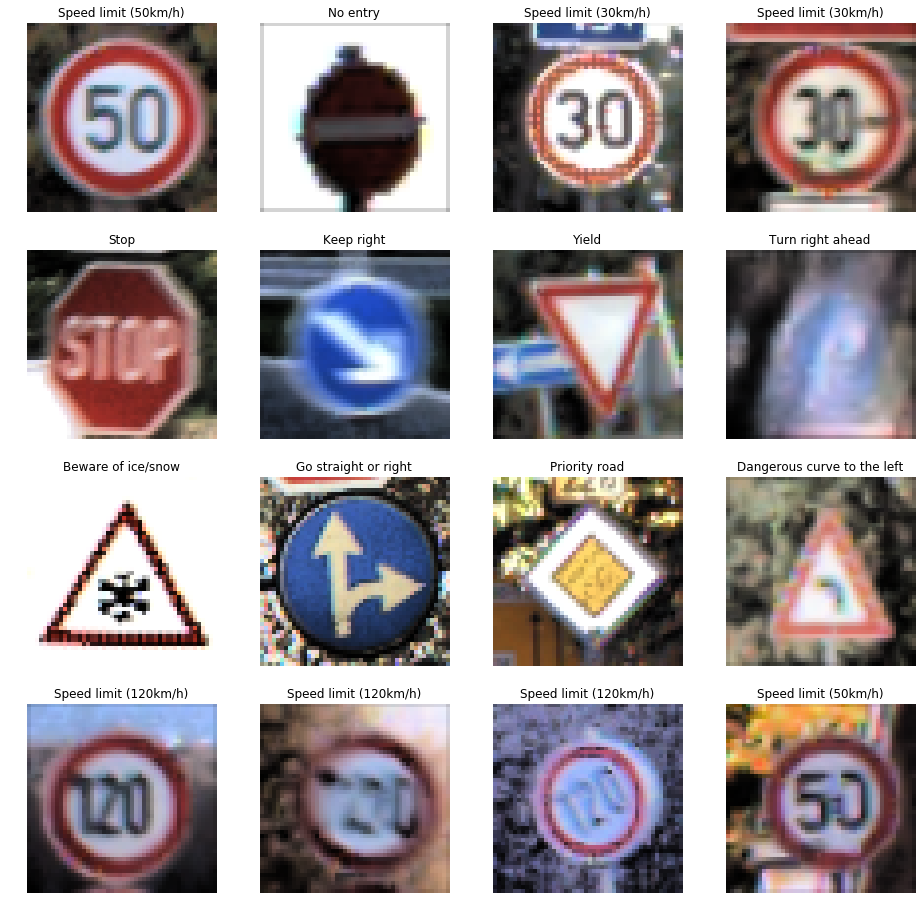

In [7]:
plot_stacked_images(X_sub,y_sub,size=size)

## Training Black-Box Model

In [8]:
def get_scores(model,X_train,y_train,X_test,y_test):
    yhat = model.predict(X_train)
    score = accuracy_score(y_train,yhat)
    print('Training Accuracy: %f' % round(score,3))    
    yhat = model.predict(X_test)
    score = accuracy_score(y_test,yhat)
    print('Test Accuracy: %f' % round(score,3))
    
def add_fc_layers(model,n_classes,fc_size=512):
    x = model.output
    x = GlobalAveragePooling2D()(x)
    #x = Flatten()(x)
    #x = Dropout(0.3)(x)
    x = Dense(fc_size,activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(fc_size,activation='relu')(x)
    yhat = Dense(n_classes,activation='softmax')(x)
    return Model(input=model.input,output=yhat)

def get_bbox_model(size,n_classes,fc_size=512,lr=0.001):
    vgg = vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(size,size,3))
    for layer in vgg.layers:
        layer.trainable = False
    model_bbox = add_fc_layers(vgg,n_classes=n_classes,fc_size=fc_size)
    opt = SGD(lr=lr,momentum=0.9, nesterov=True)
    model_bbox.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=opt)
    return model_bbox

In [16]:
model_bbox = get_bbox_model(size,Y_bbox.shape[1],fc_size=512,lr=.01)
model_bbox.fit(X_bbox,Y_bbox,batch_size=32,epochs=2,verbose=1,validation_split=0.2)

Train on 31366 samples, validate on 7842 samples
Epoch 1/2
31366/31366 [==============================] - 459s 15ms/step - loss: 1.7452 - acc: 0.4477 - val_loss: 1.4307 - val_acc: 0.5125
Epoch 2/2
31366/31366 [==============================] - 465s 15ms/step - loss: 1.2803 - acc: 0.5707 - val_loss: 1.1461 - val_acc: 0.6154


In [18]:
for layer in model_bbox.layers[10:]:
    layer.trainable = True

opt = SGD(lr=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
model_bbox.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=opt)
model_bbox.fit(X_bbox,Y_bbox,batch_size=32,epochs=3,verbose=1,validation_split=0.2)

Train on 31366 samples, validate on 7842 samples
Epoch 1/3
31366/31366 [==============================] - 1426s 45ms/step - loss: 0.7851 - acc: 0.7286 - val_loss: 0.6700 - val_acc: 0.7677
Epoch 2/3
31360/31366 [============================>.] - ETA: 0s - loss: 0.6387 - acc: 0.7787

KeyboardInterrupt: 

## Training Substitute Model

In [13]:
def get_sub_model(size,lr):
    model = Sequential()
    model.add(Conv2D(32,(3,3),padding='same',input_shape=(size,size,3),activation='relu'))
    model.add(Conv2D(32,(3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(Conv2D(64,(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(Conv2D(128,(3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation='softmax'))
    opt = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])    
    return model

model_sub = get_sub_model(size,0.01)

model_sub.fit(X_sub, Y_sub,batch_size=32,epochs=5,validation_split=0.2)

Train on 10103 samples, validate on 2526 samples
Epoch 1/5
10103/10103 [==============================] - 80s 8ms/step - loss: 3.4008 - acc: 0.0876 - val_loss: 2.5792 - val_acc: 0.2842
Epoch 2/5
10103/10103 [==============================] - 79s 8ms/step - loss: 1.7764 - acc: 0.4549 - val_loss: 1.0300 - val_acc: 0.6766
Epoch 3/5
10103/10103 [==============================] - 79s 8ms/step - loss: 0.8257 - acc: 0.7347 - val_loss: 0.4122 - val_acc: 0.8773
Epoch 4/5
10103/10103 [==============================] - 78s 8ms/step - loss: 0.4313 - acc: 0.8650 - val_loss: 0.1773 - val_acc: 0.9513
Epoch 5/5
10103/10103 [==============================] - 79s 8ms/step - loss: 0.2661 - acc: 0.9162 - val_loss: 0.1080 - val_acc: 0.9687


## Training Aversarial Examples

In [ ]:
idx = np.random.choice(len(X_sub))
X_samp = X_sub[idx][:100]

adv_crafter = FastGradientMethod(model_sub)
X_adv = adv_crafter.generate(x=X_samp, eps=0.1)

## Attacking the Black-Box Model